# QF620 Project Part IV - Dynamic Hedging

**Group 8**\
Ee Jing Michelle\
Ishani Maitra\
Jermayne Lim Jie Min\
Lim Fang Yi\
Muhammad Saqif Bin Juhaimee\
Rohen S/O Veera Kumaran

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

from scipy.stats import norm

import warnings
warnings.filterwarnings("ignore")

### Initialize Parameters


*   Set $S_0 = 100$, $\sigma = 0.2$, $r = 0.05$, $T = \frac{1}{12}$, $K = 100$, $N = 21$, $N = 84$
*   Simulate 50,000 paths for $S_t$



In [5]:
# Parameters
np.random.seed(620)

S0 = 100
sigma = 0.2
r = 0.05
T = 1/12     # 1 month
K = 100

N1 = 21      # Daily Hedging
N2 = 84      # 4x Daily Hedging

paths = 50000

### Simulate Stock Price Paths

Using Brownian Motion to simulate stock prices:

  \begin{equation*}
    S_{t+\Delta t} = S_t e^{(r-\frac{1}{2}σ^2)Δt+σ \sqrt{Δt}Z}
  \end{equation*}



In [7]:
# Brownian Motion
def simulate_Brownian_Motion(paths, steps, T):
    deltaT = T/steps
    t = np.linspace(0, T, steps+1)
    X = np.c_[np.zeros((paths, 1)),
              np.random.randn(paths, steps)]
    return t, np.cumsum(np.sqrt(deltaT) * X, axis=1)

In [8]:
# Black-Scholes Model
def BlackScholesCall(S, K, r, sigma, T):
    d1 = (np.log(S/K) + (r+sigma**2 /2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

In [9]:
# Stock Price Simulation
def simulate_Stock_Price(steps):
    t, Wt = simulate_Brownian_Motion(paths, steps, 1/12)
    t = np.linspace(0,T,steps+1)
    S = S0*np.exp((r-(sigma**2)/2)*t+sigma*Wt)
    return S

In [10]:
# Simulate Stock Paths
stockpaths21 = simulate_Stock_Price(N1)
stockpaths84 = simulate_Stock_Price(N2)

### Delta Hedging Strategy

The hedged portfolio is $V_t=\phi_tS_t+\psi_tB_t$, where

\begin{equation*}
\phi_t=\Delta_t=\frac{\partial C}{\partial S}=\Phi\left(\frac{\log\frac{S}{K}+\left(r+\frac{\sigma^2}{2}\right)T}{\sigma\sqrt{T}}\right)
\end{equation*}

and

\begin{equation*}
\psi_tB_t=-Ke^{-rT}\Phi\left(\frac{\log\frac{S}{K}+\left(r-\frac{\sigma^2}{2}\right)T}{\sigma\sqrt{T}}\right)
\end{equation*}

In [12]:
# Stock and bond holding functions
def phi(S, K, r, sigma, T):
    d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

def psi_Bt(S, K, r, sigma, T):
    d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return -K * np.exp(-r * T) * norm.cdf(d2)

In [13]:
# Delta Hedging Function
def delta_hedging(stock_paths, steps, r, sigma, K, T):

    dt = T / steps
    t_grid = np.linspace(0, T, steps + 1)
    paths = stock_paths.shape[0]

    # Initialize cumulative hedging errors
    errors = np.zeros(paths)

    # Iterate over time steps
    for i in range(steps):
        St = stock_paths[:, i]               # Stock prices at time t
        St_1 = stock_paths[:, i + 1]         # Stock prices at time t+1
        deltaT = T - t_grid[i]               # Time to maturity from current step
        changeT = t_grid[i + 1] - t_grid[i]  # Time difference between steps

        # Delta (φ)
        phi_t = phi(St, K, r, sigma, deltaT)

        # Bond Position (ψ)
        psi = psi_Bt(St, K, r, sigma, deltaT)

        # Update Hedging Error
        errors += (St_1 * phi_t + psi * np.exp(r * changeT)) - (St * phi_t + psi)

    # Add Initial Option Price
    C0 = phi(S0, K, r, sigma, T) * S0 + psi_Bt(S0, K, r, sigma, T)
    errors += C0

    # Subtract Terminal Payoff
    errors -= np.maximum(stock_paths[:, -1] - K, 0)

    return errors

### Hedging Errors

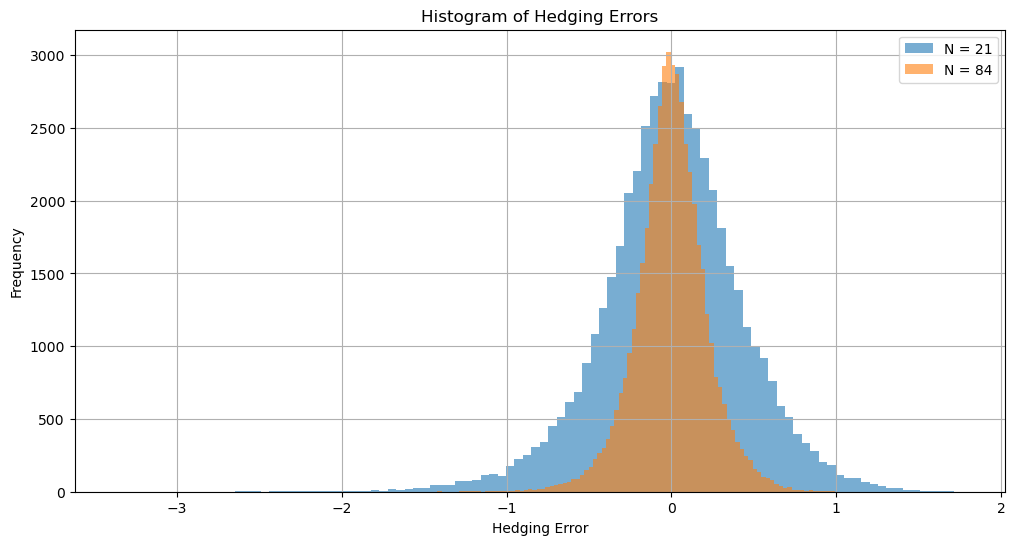

In [15]:
# Calculate hedging errors
errors21 = delta_hedging(stockpaths21, N1, r, sigma, K, T)
errors84 = delta_hedging(stockpaths84, N2, r, sigma, K, T)

# Plot histograms
plt.figure(figsize=(12, 6))
plt.hist(errors21, bins=100, alpha=0.6, label="N = 21")
plt.hist(errors84, bins=100, alpha=0.6, label="N = 84")
plt.xlabel("Hedging Error")
plt.ylabel("Frequency")
plt.title("Histogram of Hedging Errors")
plt.legend()
plt.grid(True)
plt.show()

In [16]:
# Compute initial option price
C0 = BlackScholesCall(S0, K, r, sigma, T)

# Compute statistics
summary =\
(
  pd
  .DataFrame({"Hedging Frequency": ["N=21", "N=84"],
              "Mean": [np.mean(errors21), np.mean(errors84)],
              "Standard Deviation": [np.std(errors21), np.std(errors84)],
              "Standard Deviation (% of Initial Option Price)": [np.std(errors21) / C0 * 100,
                                                                 np.std(errors84) / C0 * 100
                                                                 ]
              })
)

summary

,Hedging Frequency,Mean,Standard Deviation,Standard Deviation (% of Initial Option Price)
0,N=21,-0.002597,0.430180,17.124551
1,N=84,-0.001248,0.216545,8.620199
